In [17]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfms
import torchvision.datasets as data
import torchvision.utils as vis_utils
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as pretrained_models
import torch.nn.functional as functional
from scipy.linalg import norm
import pandas as pd
import torch.nn.functional as F
from scipy import linalg



In [2]:
import os

# Ensure the directory for saving images exists
images_dir = 'Generated_Images'
if not os.path.exists(images_dir):
    os.mkdir(images_dir)


In [3]:
torch.manual_seed(42)
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Active Device:', compute_device)

# Hyperparameters
learning_rate = 5e-5
batch_size = 64
img_dim = 64
color_channels = 3
latent_vector_size = 100
epochs = 40
disc_features = 64
gen_features = 64
class_count = 10
embedding_dim = 100
critic_iterations = 5


Active Device: cuda


In [4]:
cifar10_data = torchvision.datasets.CIFAR10(
    root="./data/CIFAR10",
    download=True,
    transform=tfms.Compose([
        tfms.Resize(img_dim),
        tfms.ToTensor(),
        tfms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
data_loader = torch.utils.data.DataLoader(
    cifar10_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)


Files already downloaded and verified


/home/snarale/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


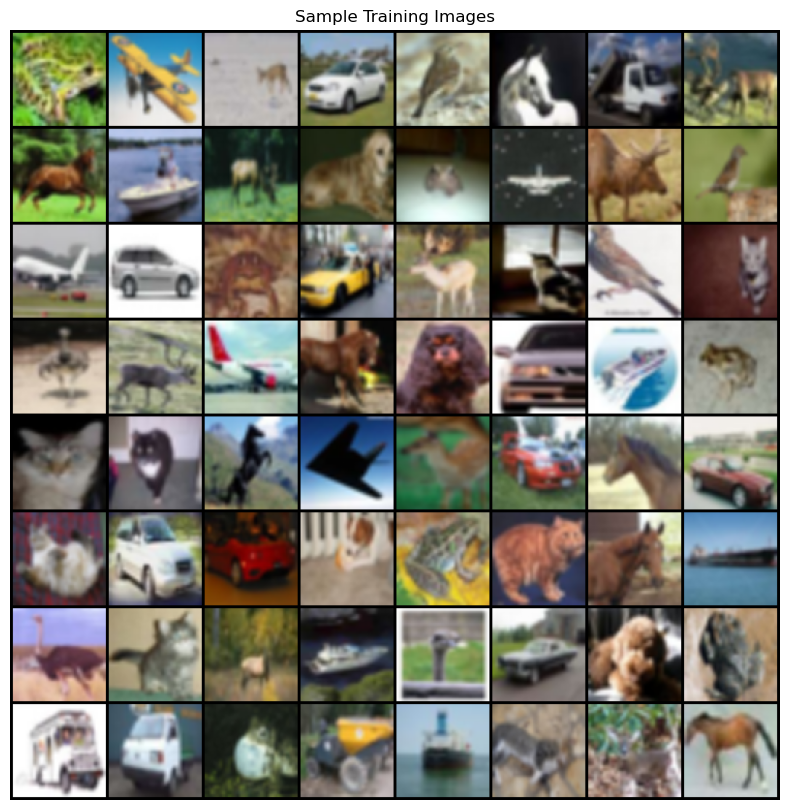

In [5]:
sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(
    np.transpose(
        vis_utils.make_grid(
            sample_batch[0].to(compute_device)[:batch_size], 
            padding=2, 
            normalize=True
        ).cpu(), 
        (1, 2, 0)
    )
)


In [6]:
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils
# import numpy as np

# # Fetch a batch of images from the DataLoader
# sample_batch = next(iter(data_loader))
# images, _ = sample_batch  # Ignore the labels

# # Visualize the batch of images
# plt.figure(figsize=(8, 8))
# plt.axis("off")
# plt.title("Sample Training Batch")
# grid = vutils.make_grid(images[:64], padding=2, normalize=True)
# plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
# plt.show()


In [7]:
class Generator(nn.Module):
    def __init__(self, class_count, img_dim, embedding_dim, noise_channels, img_channels, gen_features):
        super(Generator, self).__init__()
        self.img_dim = img_dim
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                latent_vector_size + embedding_dim, gen_features * 16, 4, 1, 0, bias=False
            ),   
            self.generator_block(gen_features * 16, gen_features * 8, 4, 2, 1),  # img: 8x8
            self.generator_block(gen_features * 8, gen_features * 4, 4, 2, 1),  # img: 16x16
            self.generator_block(gen_features * 4, gen_features * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x img_channels x 64 x 64
            nn.Tanh(),
        )
        
        self.embedding_layer = nn.Embedding(class_count, embedding_dim)

    def generator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        embedded_labels = self.embedding_layer(labels).unsqueeze(2).unsqueeze(3)
        input_tensor = torch.cat([noise, embedded_labels], dim=1)
        return self.network(input_tensor)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, class_count, img_dim, img_channels, disc_features):    
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                img_channels, disc_features, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.discriminator_block(disc_features, disc_features * 2, 4, 2, 1),  # Output: 128
            self.discriminator_block(disc_features * 2, disc_features * 4, 4, 2, 1),  # Output: 256
            self.discriminator_block(disc_features * 4, disc_features * 8, 4, 2, 1),  # Output: 512
        )
        self.validity_output = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        self.label_output = nn.Sequential(
            nn.Conv2d(512, class_count + 1, 4, 1, 0, bias=False),  # +1 for "unknown" class
            nn.LogSoftmax(dim=1)
        )
        
        self.embedding_layer = nn.Embedding(class_count, img_dim * img_dim)

    def discriminator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, input_img):
        features = self.feature_extractor(input_img)
        validity = self.validity_output(features).view(-1)
        class_labels = self.label_output(features).view(-1, 11)
        return validity, class_labels


In [9]:
def init_weights(module):
    # Apply weight initialization as per DCGAN guidelines
    for layer in module.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)

generator = Generator(
    class_count, img_dim, embedding_dim, latent_vector_size, color_channels, gen_features
).to(compute_device)

discriminator = Discriminator(
    class_count, img_dim, color_channels, disc_features
).to(compute_device)

init_weights(generator)
init_weights(discriminator)



In [10]:
generator.train()
discriminator.train()


Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (validity_output): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (label_output): Sequential(
    (0): Conv2d(512, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LogSoftmax(dim=1)
  )
  (embedding_layer): Embedding(10, 4096)
)

In [14]:
class InceptionV3Wrapper(nn.Module):
    """Pretrained InceptionV3 network for feature extraction."""
    
    DEFAULT_OUTPUT_BLOCK = 3

    BLOCK_DIMENSIONS = {
        64: 0,    # Features after first max pooling
        192: 1,   # Features after second max pooling
        768: 2,   # Pre-auxiliary classifier features
        2048: 3   # Final average pooling features
    }

    def __init__(self, output_blocks=None, resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3Wrapper, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks or [self.DEFAULT_OUTPUT_BLOCK])
        self.max_output_block = max(self.output_blocks)

        assert self.max_output_block <= 3, "Maximum block index is 3"

        self.blocks = nn.ModuleList()
        pretrained_inception = pretrained_models.inception_v3(pretrained=True)

        # Define individual blocks
        block_0 = [
            pretrained_inception.Conv2d_1a_3x3,
            pretrained_inception.Conv2d_2a_3x3,
            pretrained_inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block_0))

        if self.max_output_block >= 1:
            block_1 = [
                pretrained_inception.Conv2d_3b_1x1,
                pretrained_inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block_1))

        if self.max_output_block >= 2:
            block_2 = [
                pretrained_inception.Mixed_5b,
                pretrained_inception.Mixed_5c,
                pretrained_inception.Mixed_5d,
                pretrained_inception.Mixed_6a,
                pretrained_inception.Mixed_6b,
                pretrained_inception.Mixed_6c,
                pretrained_inception.Mixed_6d,
                pretrained_inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block_2))

        if self.max_output_block >= 3:
            block_3 = [
                pretrained_inception.Mixed_7a,
                pretrained_inception.Mixed_7b,
                pretrained_inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block_3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inputs):
        outputs = []
        x = inputs

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)

            if idx == self.max_output_block:
                break

        return outputs


block_index = InceptionV3Wrapper.BLOCK_DIMENSIONS[2048]
inception_model = InceptionV3Wrapper([block_index]).cuda()


def compute_activation_statistics(images, model, batch_size=128, feature_dim=2048, use_cuda=True):
    model.eval()
    activations = np.empty((len(images), feature_dim))

    if use_cuda:
        images = images.cuda()

    predictions = model(images)[0]

    if predictions.size(2) != 1 or predictions.size(3) != 1:
        predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))

    activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)
    mean = np.mean(activations, axis=0)
    covariance = np.cov(activations, rowvar=False)

    return mean, covariance


def frechet_distance(mean1, cov1, mean2, cov2, epsilon=1e-6):
    """Compute the Frechet Distance between two multivariate Gaussians."""
    mean1 = np.atleast_1d(mean1)
    mean2 = np.atleast_1d(mean2)
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)

    assert mean1.shape == mean2.shape, "Mean vectors have mismatched lengths"
    assert cov1.shape == cov2.shape, "Covariance matrices have mismatched dimensions"

    mean_diff = mean1 - mean2
    covariance_mean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)

    if not np.isfinite(covariance_mean).all():
        offset = np.eye(cov1.shape[0]) * epsilon
        covariance_mean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    if np.iscomplexobj(covariance_mean):
        covariance_mean = covariance_mean.real

    trace_covariance_mean = np.trace(covariance_mean)

    return mean_diff.dot(mean_diff) + np.trace(cov1) + np.trace(cov2) - 2 * trace_covariance_mean


def compute_fid_score(real_images, fake_images, model):
    mean_real, cov_real = compute_activation_statistics(real_images, model, use_cuda=True)
    mean_fake, cov_fake = compute_activation_statistics(fake_images, model, use_cuda=True)

    return frechet_distance(mean_real, cov_real, mean_fake, cov_fake)


In [15]:
fixed_noise = torch.randn(32, latent_vector_size, 1, 1).to(compute_device)
global_step = 0

disc_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

loss_criterion = nn.BCELoss()
step_counter_list = []
step_counter = 0
generator_loss_list = []
discriminator_loss_list = []
generated_images = []


In [18]:
gen_loss_history = []
disc_loss_history = []
generated_images = []
iteration = 0
fid_scores = []

print("!! Training Started !!")

# Start timing
start_time = time.time()

for epoch_idx in range(1, epochs + 1):
    for batch_idx, (real_images, labels) in enumerate(data_loader):
        real_images = real_images.to(compute_device)
        labels = labels.to(compute_device)
        batch_size = real_images.size(0)
        fake_class_label = 10 * torch.ones((batch_size,), dtype=torch.long).to(compute_device)

        discriminator.zero_grad()

        ###########################
        # Train Discriminator
        ###########################

        # Train with real images
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float).to(compute_device)
        disc_real_out, disc_real_labels = discriminator(real_images)
        loss_disc_real_val = loss_criterion(disc_real_out, real_labels)
        loss_disc_real_label = F.nll_loss(disc_real_labels, labels)
        real_disc_loss = loss_disc_real_val + loss_disc_real_label
        real_disc_loss.backward()

        # Train with fake images
        random_labels = torch.randint(0, 10, (batch_size,), dtype=torch.long).to(compute_device)
        noise_vector = torch.randn(batch_size, latent_vector_size, 1, 1).to(compute_device)
        fake_images = generator(noise_vector, random_labels)
        disc_fake_out, disc_fake_labels = discriminator(fake_images.detach())
        fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float).to(compute_device)
        loss_disc_fake_val = loss_criterion(disc_fake_out, fake_labels)
        loss_disc_fake_label = F.nll_loss(disc_fake_labels, fake_class_label)
        fake_disc_loss = loss_disc_fake_val + loss_disc_fake_label
        fake_disc_loss.backward()

        # Average discriminator loss
        discriminator_loss = (real_disc_loss + fake_disc_loss) / 2
        disc_optimizer.step()

        ###########################
        # Train Generator
        ###########################
        generator.zero_grad()
        noise_vector = torch.randn(batch_size, latent_vector_size, 1, 1).to(compute_device)
        random_labels = torch.randint(0, 10, (batch_size,), dtype=torch.long).to(compute_device)
        real_labels.fill_(1.0)
        generated_images_batch = generator(noise_vector, random_labels)
        gen_out, gen_out_labels = discriminator(generated_images_batch)

        # Generator loss
        gen_loss_real = loss_criterion(gen_out, real_labels)
        gen_loss_label = F.nll_loss(gen_out_labels, random_labels)
        generator_loss = gen_loss_real + gen_loss_label
        generator_loss.backward()
        gen_optimizer.step()

        # Save losses
        gen_loss_history.append(generator_loss.detach().cpu())
        disc_loss_history.append(discriminator_loss.detach().cpu())

        # Save generated images for every 500 iterations
        if (iteration % 500 == 0) or (epoch_idx == epochs and batch_idx == len(data_loader) - 1):
            with torch.no_grad():
                fixed_fake_images = generator(noise_vector, random_labels).detach().cpu()
            generated_images.append(vis_utils.make_grid(fixed_fake_images, padding=2, normalize=True))

        iteration += 1

    # Calculate FID
    fid_score = compute_fid_score(real_images, fake_images, inception_model)
    fid_scores.append(fid_score)

    if epoch_idx % 5 == 0:
        print(
            f"Epoch [{epoch_idx}/{epochs}] Batch {batch_idx}/{len(data_loader)} "
            f"Discriminator Loss: {discriminator_loss:.3f}, Generator Loss: {generator_loss:.3f}, FID Score: {fid_score:.3f}"
        )

    # Save generated and real images for each epoch
    os.makedirs('Results/ACGAN_FAKE', exist_ok=True)
    os.makedirs('Results/ACGAN_REAL', exist_ok=True)
    generated_images_epoch = generator(noise_vector, random_labels).detach()
    vis_utils.save_image(
        generated_images_epoch, f'Results/ACGAN_FAKE/ACGAN_epoch_{epoch_idx:03d}.png', normalize=True
    )
    vis_utils.save_image(
        real_images, f'Results/ACGAN_REAL/ACGAN_epoch_{epoch_idx:03d}.png', normalize=True
    )

end_time = time.time()
print(f'\n\nElapsed Time: {end_time - start_time:.2f} seconds.')


!! Training Started !!
Epoch [5/40] Batch 781/782 Discriminator Loss: 2.121, Generator Loss: 2.553, FID Score: 453.036
Epoch [10/40] Batch 781/782 Discriminator Loss: 1.940, Generator Loss: 2.812, FID Score: 384.269
Epoch [15/40] Batch 781/782 Discriminator Loss: 1.579, Generator Loss: 3.998, FID Score: 327.558
Epoch [20/40] Batch 781/782 Discriminator Loss: 1.617, Generator Loss: 3.702, FID Score: 322.420
Epoch [25/40] Batch 781/782 Discriminator Loss: 1.421, Generator Loss: 3.334, FID Score: 316.479
Epoch [30/40] Batch 781/782 Discriminator Loss: 1.468, Generator Loss: 3.746, FID Score: 374.675
Epoch [35/40] Batch 781/782 Discriminator Loss: 1.340, Generator Loss: 3.989, FID Score: 350.281
Epoch [40/40] Batch 781/782 Discriminator Loss: 1.205, Generator Loss: 1.699, FID Score: 301.711


Elapsed Time: 2204.70 seconds.


In [19]:
# Ensure the directory for saving loss data exists
os.makedirs('Results/Loss_Data', exist_ok=True)

# Save generator and discriminator loss histories
np.save('Results/Loss_Data/ACGAN_GLoss', gen_loss_history)
np.save('Results/Loss_Data/ACGAN_DLoss', disc_loss_history)


In [22]:
# Load generator and discriminator loss histories
gen_loss_history = np.load('Results/Loss_Data/ACGAN_GLoss.npy')
disc_loss_history = np.load('Results/Loss_Data/ACGAN_DLoss.npy')


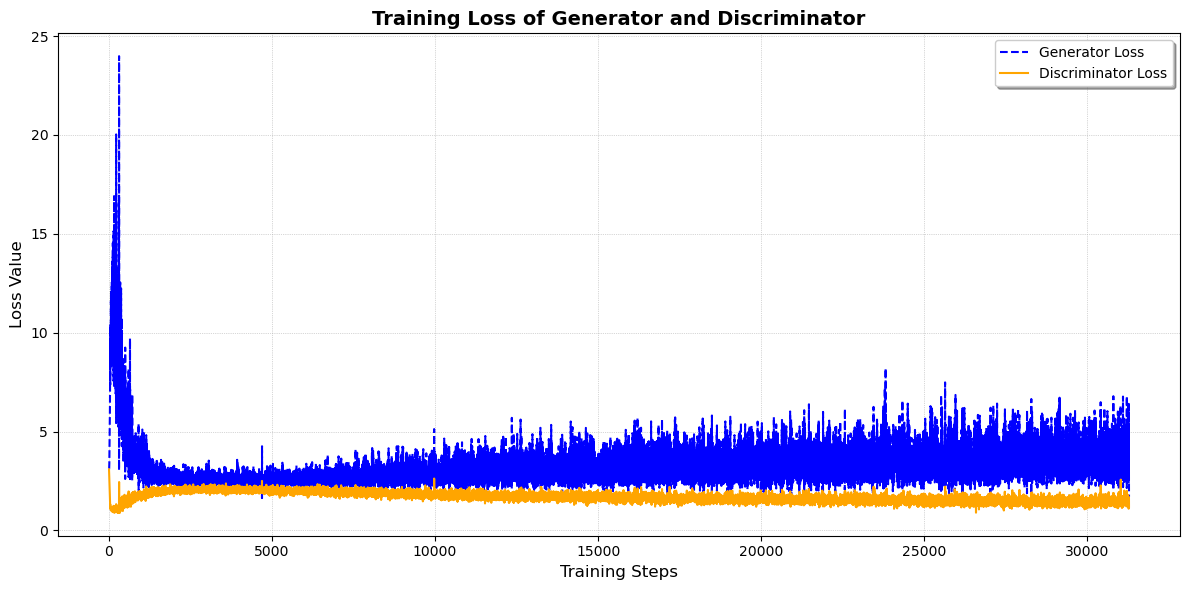

In [30]:
plt.figure(figsize=(12, 6))  # Slightly larger figure size
plt.title("Training Loss of Generator and Discriminator", fontsize=14, fontweight='bold')
plt.plot(gen_loss_history, linestyle='--', linewidth=1.5, color='blue', label="Generator Loss")
plt.plot(disc_loss_history, linestyle='-', linewidth=1.5, color='orange', label="Discriminator Loss")
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
plt.grid(visible=True, linestyle=':', linewidth=0.5)  # Add a grid with dotted lines
plt.tight_layout()  # Automatically adjusts subplots to fit in the figure
plt.savefig('Results/LossGraph.png', format='png', dpi=120, bbox_inches='tight')  # Changed file format and dpi
plt.show()


/home/snarale/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


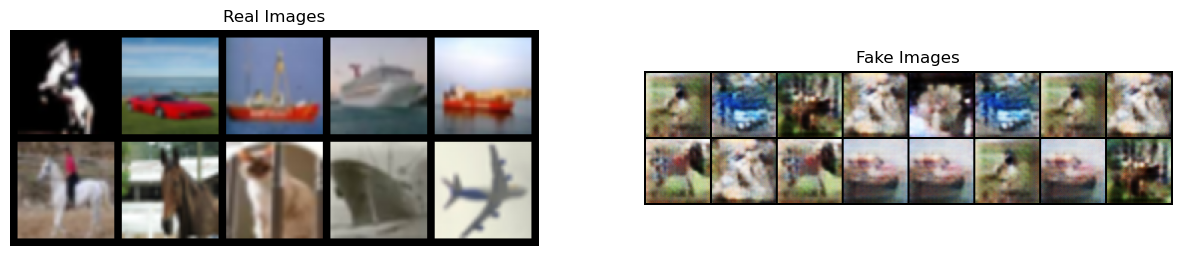

In [24]:
# Grab a batch of real images from the data loader
real_batch = next(iter(data_loader))

# Plot real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vis_utils.make_grid(real_batch[0].to(compute_device)[:10], nrow=5, padding=5, normalize=True).cpu(),
        (1, 2, 0)
    )
)

# Plot fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))

# Save the plot
plt.savefig('Results/WGANGP_BEST_FAKE_32.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()



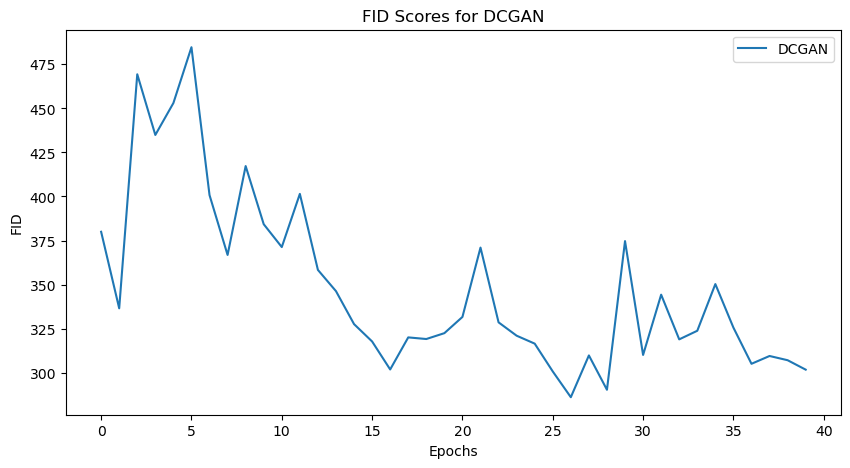

In [25]:
plt.figure(figsize=(10, 5))
plt.title("FID Scores for DCGAN")
plt.plot(fid_scores, label="DCGAN")
# plt.plot(wgan_fid_scores, label="WGAN")  # Uncomment if WGAN scores are available
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [26]:
# Ensure the directory for saving FID scores exists
os.makedirs('Results/FID_score', exist_ok=True)

# Save FID scores
np.save('Results/FID_score/ACGAN_FID', fid_scores)


In [27]:
np.min(fid_scores), np.max(fid_scores), np.mean(fid_scores), fid_scores[-5]


(286.05636624135667, 484.73093604402436, 348.4981263574313, 325.57262918241236)

In [28]:
np.mean(gen_loss_history), np.mean(disc_loss_history), np.min(gen_loss_history), np.min(disc_loss_history), gen_loss_history[-1], disc_loss_history[-1]


(3.284137, 1.687788, 1.6344869, 0.88763785, 1.6987841, 1.204936)